In [1]:
%env CUDA_VISIBLE_DEVICES=1

import os
from openTSNE import TSNE
import tnse_utils as utils
import numpy as np
import torch
from omegaconf import OmegaConf

from pit.util import instantiate_from_config
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from PIL import Image
from glob import glob
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader
from pit.util import instantiate_from_config
from functools import partial
import torchvision.transforms.v2 as transforms

class SimpleDataset(VisionDataset):
    def __init__(self, root: str, image_size=256):
        super().__init__()
        self.transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

        if root.endswith(".txt"):
            with open(root) as f:
                lines = f.readlines()
            self.fpaths = [line.strip("\n") for line in lines]
        else:
            self.fpaths = sorted(glob(root + "/**/*.JPEG", recursive=True))
            self.fpaths += sorted(glob(root + "/**/*.jpg", recursive=True))
            self.fpaths += sorted(glob(root + "/**/*.png", recursive=True))

        self.fpaths = self.fpaths[:100]
        assert len(self.fpaths) > 0, "File list is empty. Check the root."

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, index: int):
        fpath = self.fpaths[index]
        img = Image.open(fpath).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return {
            "img": img,
            "fpath": fpath,
        }


class ComplexDataset(VisionDataset):
    def __init__(self,):
        super().__init__()
        self.names = [
            "kit fox",
            "grey whale",
            "panda",
            "Egyptian cat",
            "sea lion",
        ]

        self.datasets = [
            SimpleDataset("/workspace/cogview_dev/xutd/xu/datasets/ILSVRC/Data/CLS-LOC/train/n02119789"),
            SimpleDataset("/workspace/cogview_dev/xutd/xu/datasets/ILSVRC/Data/CLS-LOC/train/n02066245"),
            SimpleDataset("/workspace/cogview_dev/xutd/xu/datasets/ILSVRC/Data/CLS-LOC/train/n02509815"),
            SimpleDataset("/workspace/cogview_dev/xutd/xu/datasets/ILSVRC/Data/CLS-LOC/train/n02124075"),
            SimpleDataset("/workspace/cogview_dev/xutd/xu/datasets/ILSVRC/Data/CLS-LOC/train/n02077923"),
        ]


    def __len__(self):
        return 500

    def __getitem__(self, index: int):
        dic = self.datasets[index%5].__getitem__(index//5)
        dic["label"] = self.names[index%5]
        return dic


image_dataset = ComplexDataset()

image_dataloader = DataLoader(
    image_dataset,
    8,
    shuffle=False,
    num_workers=32,
    drop_last=True,
)

config = OmegaConf.load("/workspace/cogview_dev/xutd/xu/pytorch-image-tokenizer/configs/sd3unet_gq_0.25_gaussian.yaml")
model = instantiate_from_config(config.model)
model.load_state_dict(torch.load("/workspace/cogview_dev/xutd/xu/pytorch-image-tokenizer/models_256/sd3unet_gq_0.25.ckpt",map_location=torch.device('cpu'))["state_dict"], strict=False)
model = model.eval().cuda()

latents = []
labels = []
for di, batch in tqdm(enumerate(image_dataloader)):
    if di >= 100:
        break
    img = batch["img"].cuda()
    labels += batch["label"]
    with torch.no_grad():
        zhat, _ = model.encode(img, return_reg_log=True)
    latents.append(zhat)

latents = torch.cat(latents, dim=0)
latents = latents.reshape(latents.shape[0], -1)
train_data = latents.cpu().numpy()

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
embedding_train = tsne.fit(train_data)

env: CUDA_VISIBLE_DEVICES=1


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
no module 'xformers'. Processing without...
no module 'xformers'. Processing without...
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated 

loaded pretrained LPIPS loss from /workspace/cogview_dev/xutd/xu/models/hub/pit/modules/lpips/loss/vgg.pth
Missing keys:  []
Restored from ./models_256/sd3unet_gq_0.25.ckpt


62it [00:18,  3.41it/s]


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 5.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.14 seconds
===> Running optimization with exaggeration=12.00, lr=41.33 for 250 iterations...
Iteration   50, KL divergence 0.9801, 50 iterations in 0.1308 sec
Iteration  100, KL divergence -0.8780, 50 iterations in 0.0223 sec
Iteration  150, KL divergence -1.9378, 50 iterations in 0.0150 sec
Iteration  200, KL divergence -3.2208, 50 iterations in 0.0133 sec
Iteration  250, KL divergence -3.7314, 50 iterations in 0.0124 sec
   --> Time elapsed: 0.19 seconds
===> Running optimization with exaggeration=1.00, lr=49

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(embedding_train[:,0],embedding_train[:,1], label=labels)
plt.legend()
plt.show()


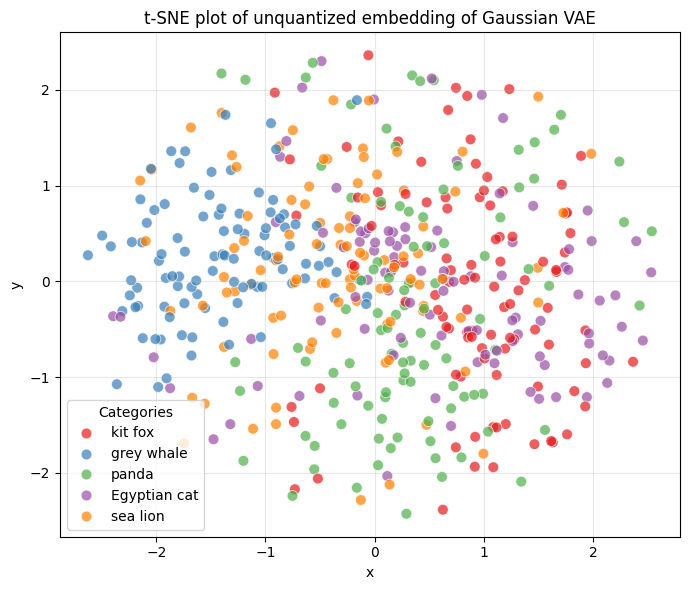

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 创建DataFrame
df = pd.DataFrame({
    'x': embedding_train[:, 1],
    'y': embedding_train[:, 0],
    'category': labels
})

plt.figure(figsize=(7, 6))
sns.scatterplot(data=df, x='x', y='y', hue='category', palette='Set1', s=60, alpha=0.7)
plt.title('t-SNE plot of unquantized embedding of Gaussian VAE')
plt.legend(title='Categories')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()